# IDEC implementation on TensorFlow

In [ ]:
import os
import cv2
import sys
import math
import imageio
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from sklearn import metrics
import skimage.metrics as ski
from keras.models import Model
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model
from sklearn.metrics.pairwise import cosine_similarity
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

sys.path.append("/home/NETID/fiona123/css590/scripts")
from DEC import *

In [1]:
"""
Implementation for Improved Deep Embedded Clustering as described in paper:
        Xifeng Guo, Long Gao, Xinwang Liu, Jianping Yin. Improved Deep Embedded Clustering with Local Structure
        Preservation. IJCAI 2017.
Author:
    Xifeng Guo. 2017.4.30
"""
class IDEC(object):
    def __init__(self,
                 dims,
                 n_clusters=10,
                 alpha=1.0,
                 batch_size=256):

        super(IDEC, self).__init__()

        self.dims = dims
        print(dims)
        print("==")
        self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.batch_size = batch_size
        self.autoencoder = autoencoder(self.dims)

    def initialize_model(self, ae_weights=None, gamma=0.1, optimizer='adam'):
        if ae_weights is not None:
            self.autoencoder.load_weights(ae_weights)
            print('Pretrained AE weights are loaded successfully.')
        else:
            print('ae_weights must be given. E.g.')
            print('    python IDEC.py mnist --ae_weights weights.h5')
            exit()

        hidden = self.autoencoder.get_layer(name='encoder_%d' % (self.n_stacks - 1)).output
        self.encoder = Model(inputs=self.autoencoder.input, outputs=hidden)

        # prepare IDEC model
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(hidden)
        self.model = Model(inputs=self.autoencoder.input,
                           outputs=[clustering_layer, self.autoencoder.output])
        self.model.compile(loss={'clustering': 'kld', 'decoder_0': 'mse'},
                           loss_weights=[gamma, 1],
                           optimizer=optimizer)

    def load_weights(self, weights_path):  # load weights of IDEC model
        self.model.load_weights(weights_path)

    def extract_feature(self, x):  # extract features from before clustering layer
        encoder = Model(self.model.input, self.model.get_layer('encoder_%d' % (self.n_stacks - 1)).output)
        return encoder.predict(x)

    def predict_clusters(self, x):  # predict cluster labels using the output of clustering layer
        q, _ = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):  # target distribution P which enhances the discrimination of soft label Q
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def clustering(self, x,
                   tol=1e-3,
                   update_interval=140,
                   maxiter=2e4,
                   save_dir='./results/idec'):

        print('Update interval', update_interval)
        save_interval = x.shape[0] / self.batch_size * 5  # 5 epochs
        print('Save interval', save_interval)

        # initialize cluster centers using k-means
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = y_pred
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # logging file
        import csv, os
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        logfile = open(save_dir + '/idec_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'L', 'Lc', 'Lr'])
        logwriter.writeheader()

        loss = [0, 0, 0]
        index = 0
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q, _ = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                y_pred_last = y_pred
               
                # check stop criterion
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            if (index + 1) * self.batch_size > x.shape[0]:
                loss = self.model.train_on_batch(x=x[index * self.batch_size::],
                                                 y=[p[index * self.batch_size::], x[index * self.batch_size::]])
                index = 0
            else:
                loss = self.model.train_on_batch(x=x[index * self.batch_size:(index + 1) * self.batch_size],
                                                 y=[p[index * self.batch_size:(index + 1) * self.batch_size],
                                                    x[index * self.batch_size:(index + 1) * self.batch_size]])
                index += 1

            # save intermediate model
            if ite % save_interval == 0:
                # save IDEC model checkpoints
                print('saving model to:', save_dir + '/IDEC_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/IDEC_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to:', save_dir + '/IDEC_model_final.h5')
        self.model.save_weights(save_dir + '/IDEC_model_final.h5')
        
        return y_pred

In [19]:
"""
Implementation for creating ssim image based on all the heatmaps
Author:
    Jeffmur - GeoLife
"""

def ssimImage(df):
    dim = df.shape
    img = Image.new("RGB", (dim[0], dim[1]), color="red")
    pixels = img.load()

    for row in df.itertuples():
        # Need row index for assignment
        for c in range(1, len(row)):
            # Capture data point @ [row, column]
            data = row[c]

            freq = int(255 * data)

            pixels[row[0], c - 1] = (0, freq, 0)
    return img


def ssim(fn, fns):
    imageA = cv2.imread(fn)
    all_scores = []

    for f in fns:
        imageB = cv2.imread(f)
        score = ski.structural_similarity(imageA, imageB, gaussian_weights=True, multichannel=True)
        all_scores.append(score)

    return all_scores

def createSSIMimage(data_directory):
    parseDir = Path(data_directory).rglob("*.png")
    
    all = sorted(parseDir, key=lambda i: os.path.splitext(os.path.basename(i))[0])
    files = [str(x) for x in all]
    print(files)
    df = pd.DataFrame(index=range(len(files)),columns=range(len(files)))
    to_append = []
    i = 0
    for A in tqdm(files):
        to_append = ssim(A, files[:])   
        df.loc[i] = to_append
        i+=1

    return df, ssimImage(df)

## Load GeolifeTrajectories heatmaps

In [ ]:
# Load the data from ResizedHeatMap_28 directory and save as one numpy array

def load_geolife():
    stream = os.popen('find /data/fiona123/GeolifeTrajectories/ResizedHeatMap_28/ -type f -print | wc -l')
    output = stream.readlines()
    img_count = output[0].strip("\n")
    
    root = "/data/fiona123/GeolifeTrajectories/ResizedHeatMap_28/"
    count = 0
    img_path = [None] * int(img_count)
    for path, subdirs, files in os.walk(root):
        for name in files:
            img_path[count] = str(os.path.join(path, name))
            count += 1

    x = np.array([np.array(Image.open(fname)) for fname in img_path])

    x = x.reshape((x.shape[0], -1))
    x = np.divide(x, 50.) # Normalize as mentioned in the paper

    return x, img_path

In [4]:
# Load dataset
x, img_path = load_geolife()

(843, 28, 28)
0 238
0.0 4.76
(843, 784)


## Perform clustering using autoencoder weights in IDEC model

In [5]:
# Prepare the IDEC model
n_clust = 10

optimizer = SGD(learning_rate=0.01, momentum=0.99)
idec = IDEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clust, batch_size=16)
idec.initialize_model(ae_weights='/data/fiona123/GeolifeTrajectories/data-and-models/ae_weights/mnist_ae_weights.h5', gamma=0.1, optimizer=optimizer)
plot_model(idec.model, to_file='idec_model.png', show_shapes=True)
idec.model.summary()

[784, 500, 500, 2000, 10]
==
Pretrained AE weights are loaded successfully.
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder_0 (Dense)               (None, 500)          392500      input[0][0]                      
__________________________________________________________________________________________________
encoder_1 (Dense)               (None, 500)          250500      encoder_0[0][0]                  
__________________________________________________________________________________________________
encoder_2 (Dense)               (None, 2000)         1002000     encoder_1[0][0]                  
________________

In [6]:
# Extract clustering layer outputs

y_pred = idec.clustering(x, tol=0.01, maxiter=2e4,
                             update_interval=25, save_dir='/data/fiona123/GeolifeTrajectories/IDEC')

print(y_pred)

Update interval 25
Save interval 263.4375
Initializing cluster centers with k-means.
saving model to: /data/fiona123/GeolifeTrajectories/IDEC/IDEC_model_0.h5
delta_label  0.0071174377224199285 < tol  0.01
Reached tolerance threshold. Stopping training.
saving model to: /data/fiona123/GeolifeTrajectories/IDEC/IDEC_model_final.h5
[2 1 2 2 2 8 8 5 5 6 5 1 1 1 1 0 5 6 2 2 5 5 2 0 0 5 2 8 2 0 2 9 5 0 2 1 0
 0 6 0 0 0 2 0 8 1 0 6 0 6 0 0 9 2 0 2 7 2 0 2 0 2 2 2 0 9 3 5 6 2 3 2 0 3
 2 8 3 2 3 2 0 1 1 6 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 6 8 7 1 0 0 0 2 3 2 1
 2 0 1 2 2 8 8 8 9 9 5 8 2 5 5 9 5 1 2 5 0 5 2 6 1 2 2 2 3 0 5 8 5 5 5 2 5
 5 6 5 5 1 9 5 5 5 9 5 5 5 5 9 5 5 5 5 5 5 9 5 9 5 5 5 5 5 9 5 5 0 0 1 0 8
 0 8 8 8 9 5 8 2 8 2 8 8 8 1 1 3 3 3 2 6 8 8 8 8 9 6 9 6 1 1 1 1 9 9 1 1 1
 9 1 6 1 1 1 1 2 1 1 1 6 2 2 2 2 2 2 1 1 5 2 6 2 2 5 5 5 5 5 2 0 9 5 9 5 2
 8 8 6 0 6 6 2 2 0 0 0 0 1 2 2 8 8 6 4 2 0 0 2 5 1 6 2 2 7 7 7 1 7 7 7 7 7
 7 7 7 7 7 7 7 1 8 3 8 3 8 8 2 2 5 0 0 2 2 2 2 5 2 5 0 0 1 5 6 5 9 0 0

## Extract last layer decoder output
### (To calculate SSIM metric of autoencoder output on GeoLife dataset)

In [7]:
# Iterate through layers to get keras layer output of "decoder_0"

for layerIndex, layer in enumerate(idec.model.layers):
    if(layer.name == "decoder_0"):
        func = K.function([idec.model.get_layer(index=0).input], layer.output)
        layerOutput = func([x])  # input_data is a numpy array
        print(layerOutput.shape)
        output = np.reshape(layerOutput, (843, 28,28)) # no.of.users, img.dim1, img.dim2
        print(output.shape)

<class 'numpy.ndarray'>
(843, 784)
(843, 28, 28)


In [8]:
# Map the output layer back to uint8 type of range 0-255

output_array = np.multiply(output,50.)
output_array = output_array.astype(int)
output_array[output_array<0] = 0
output_array[output_array>255] = 255
print(np.min(output_array),np.max(output_array))

0 255


In [9]:
# Save decoder layer outputs as images

path = "/data/fiona123/GeolifeTrajectories/DecodedOutputHeatMap/"
for i in tqdm(range(output.shape[0])):
    img_array = output_array[i,:,:]
    imageio.imwrite(path + str(i) + '.png', img_array)

  0%|          | 0/843 [00:00<?, ?it/s]Lossy conversion from int64 to uint8. Range [0, 40]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 89]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 41]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 41]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 43]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 98]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 89]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 104]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion

## Visualize clusters from IDEC model

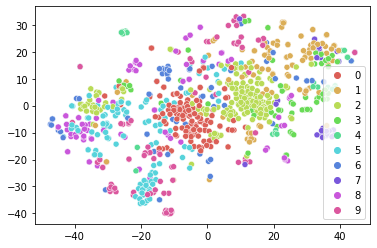

In [11]:
# T-sne
tsne = TSNE(n_components = 2, random_state=0)
tsne_res = tsne.fit_transform(x)

sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = y_pred, palette = sns.hls_palette(10), legend = 'full');

## Manually view heatmaps of each cluster

In [12]:
output_dict = {}
for key, value in zip(img_path, y_pred):
    output_dict[key] = value

In [13]:
# Create a dictionary of key - image_path and value - predicted cluster number

from itertools import groupby
import operator
by_value = operator.itemgetter(1)
output = [dict(g) for k, g in groupby(sorted(output_dict.items(), key = by_value), by_value)]

In [41]:
# Function that lets you view a cluster

def view_cluster(cluster):
    plt.figure(figsize = (50,50));
    filtered = list(output[i].keys())
    #filter_output = filtered[:7]
    
    # plot each image in the cluster
    for index, file in enumerate(filtered):
        plt.subplot(15,15,index+1);
        user = str(file.split("/")[5])
        date = str(file.split("/")[6]).replace('.png', '') 
        plt.gca().set_title(f'Cluster {cluster} - User {user} - Date {date}', fontsize=8)
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

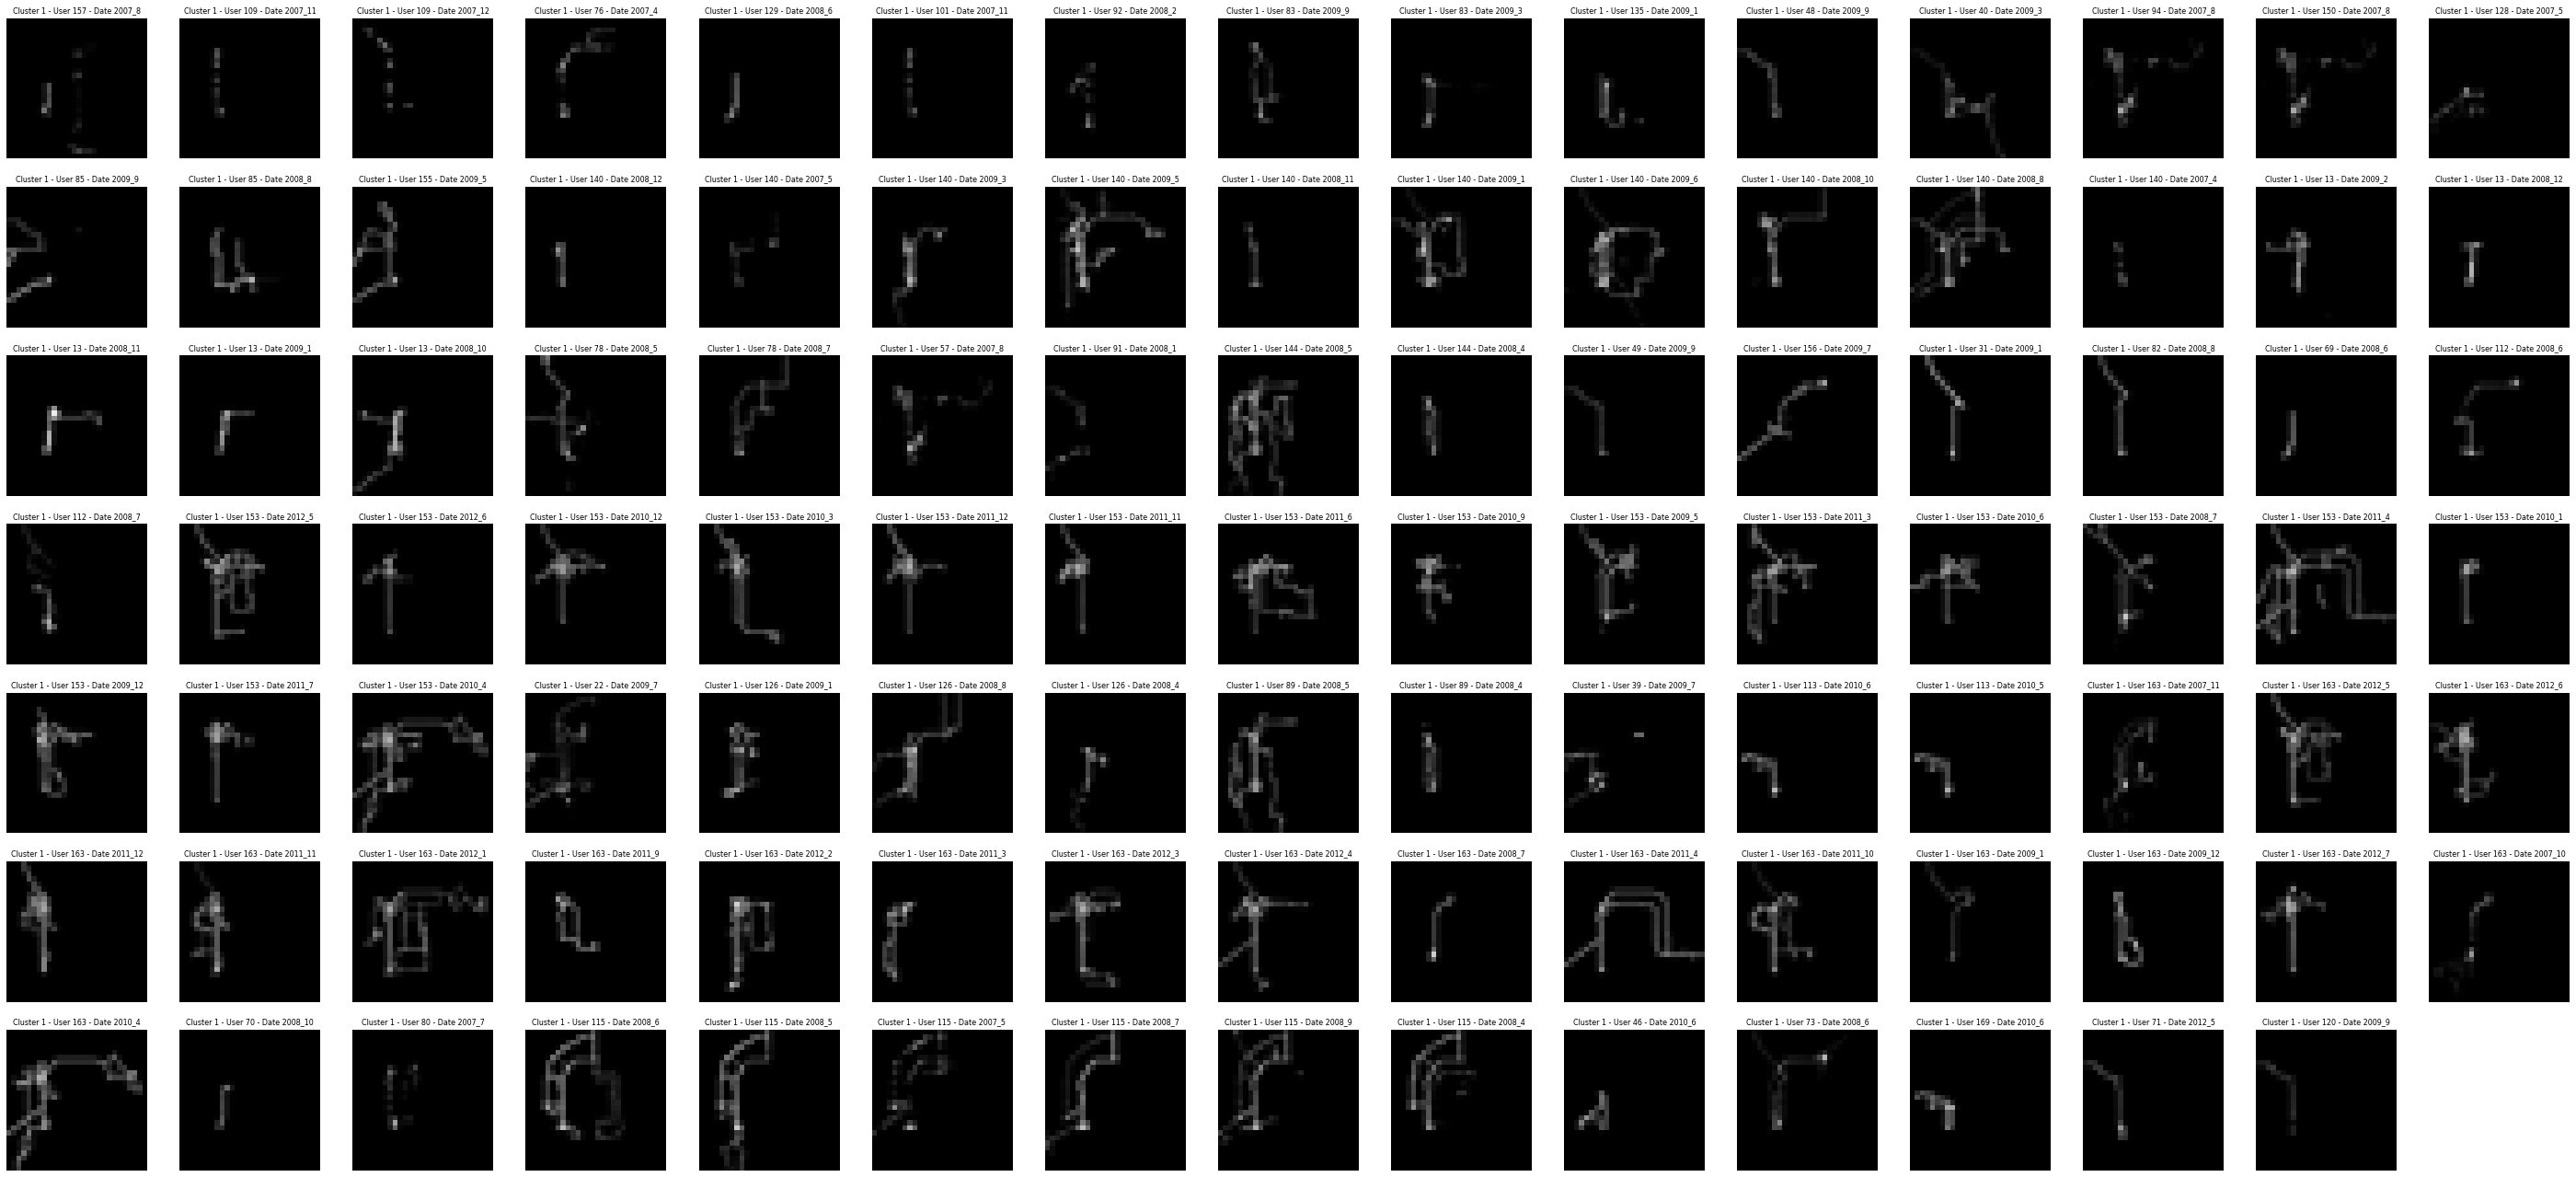

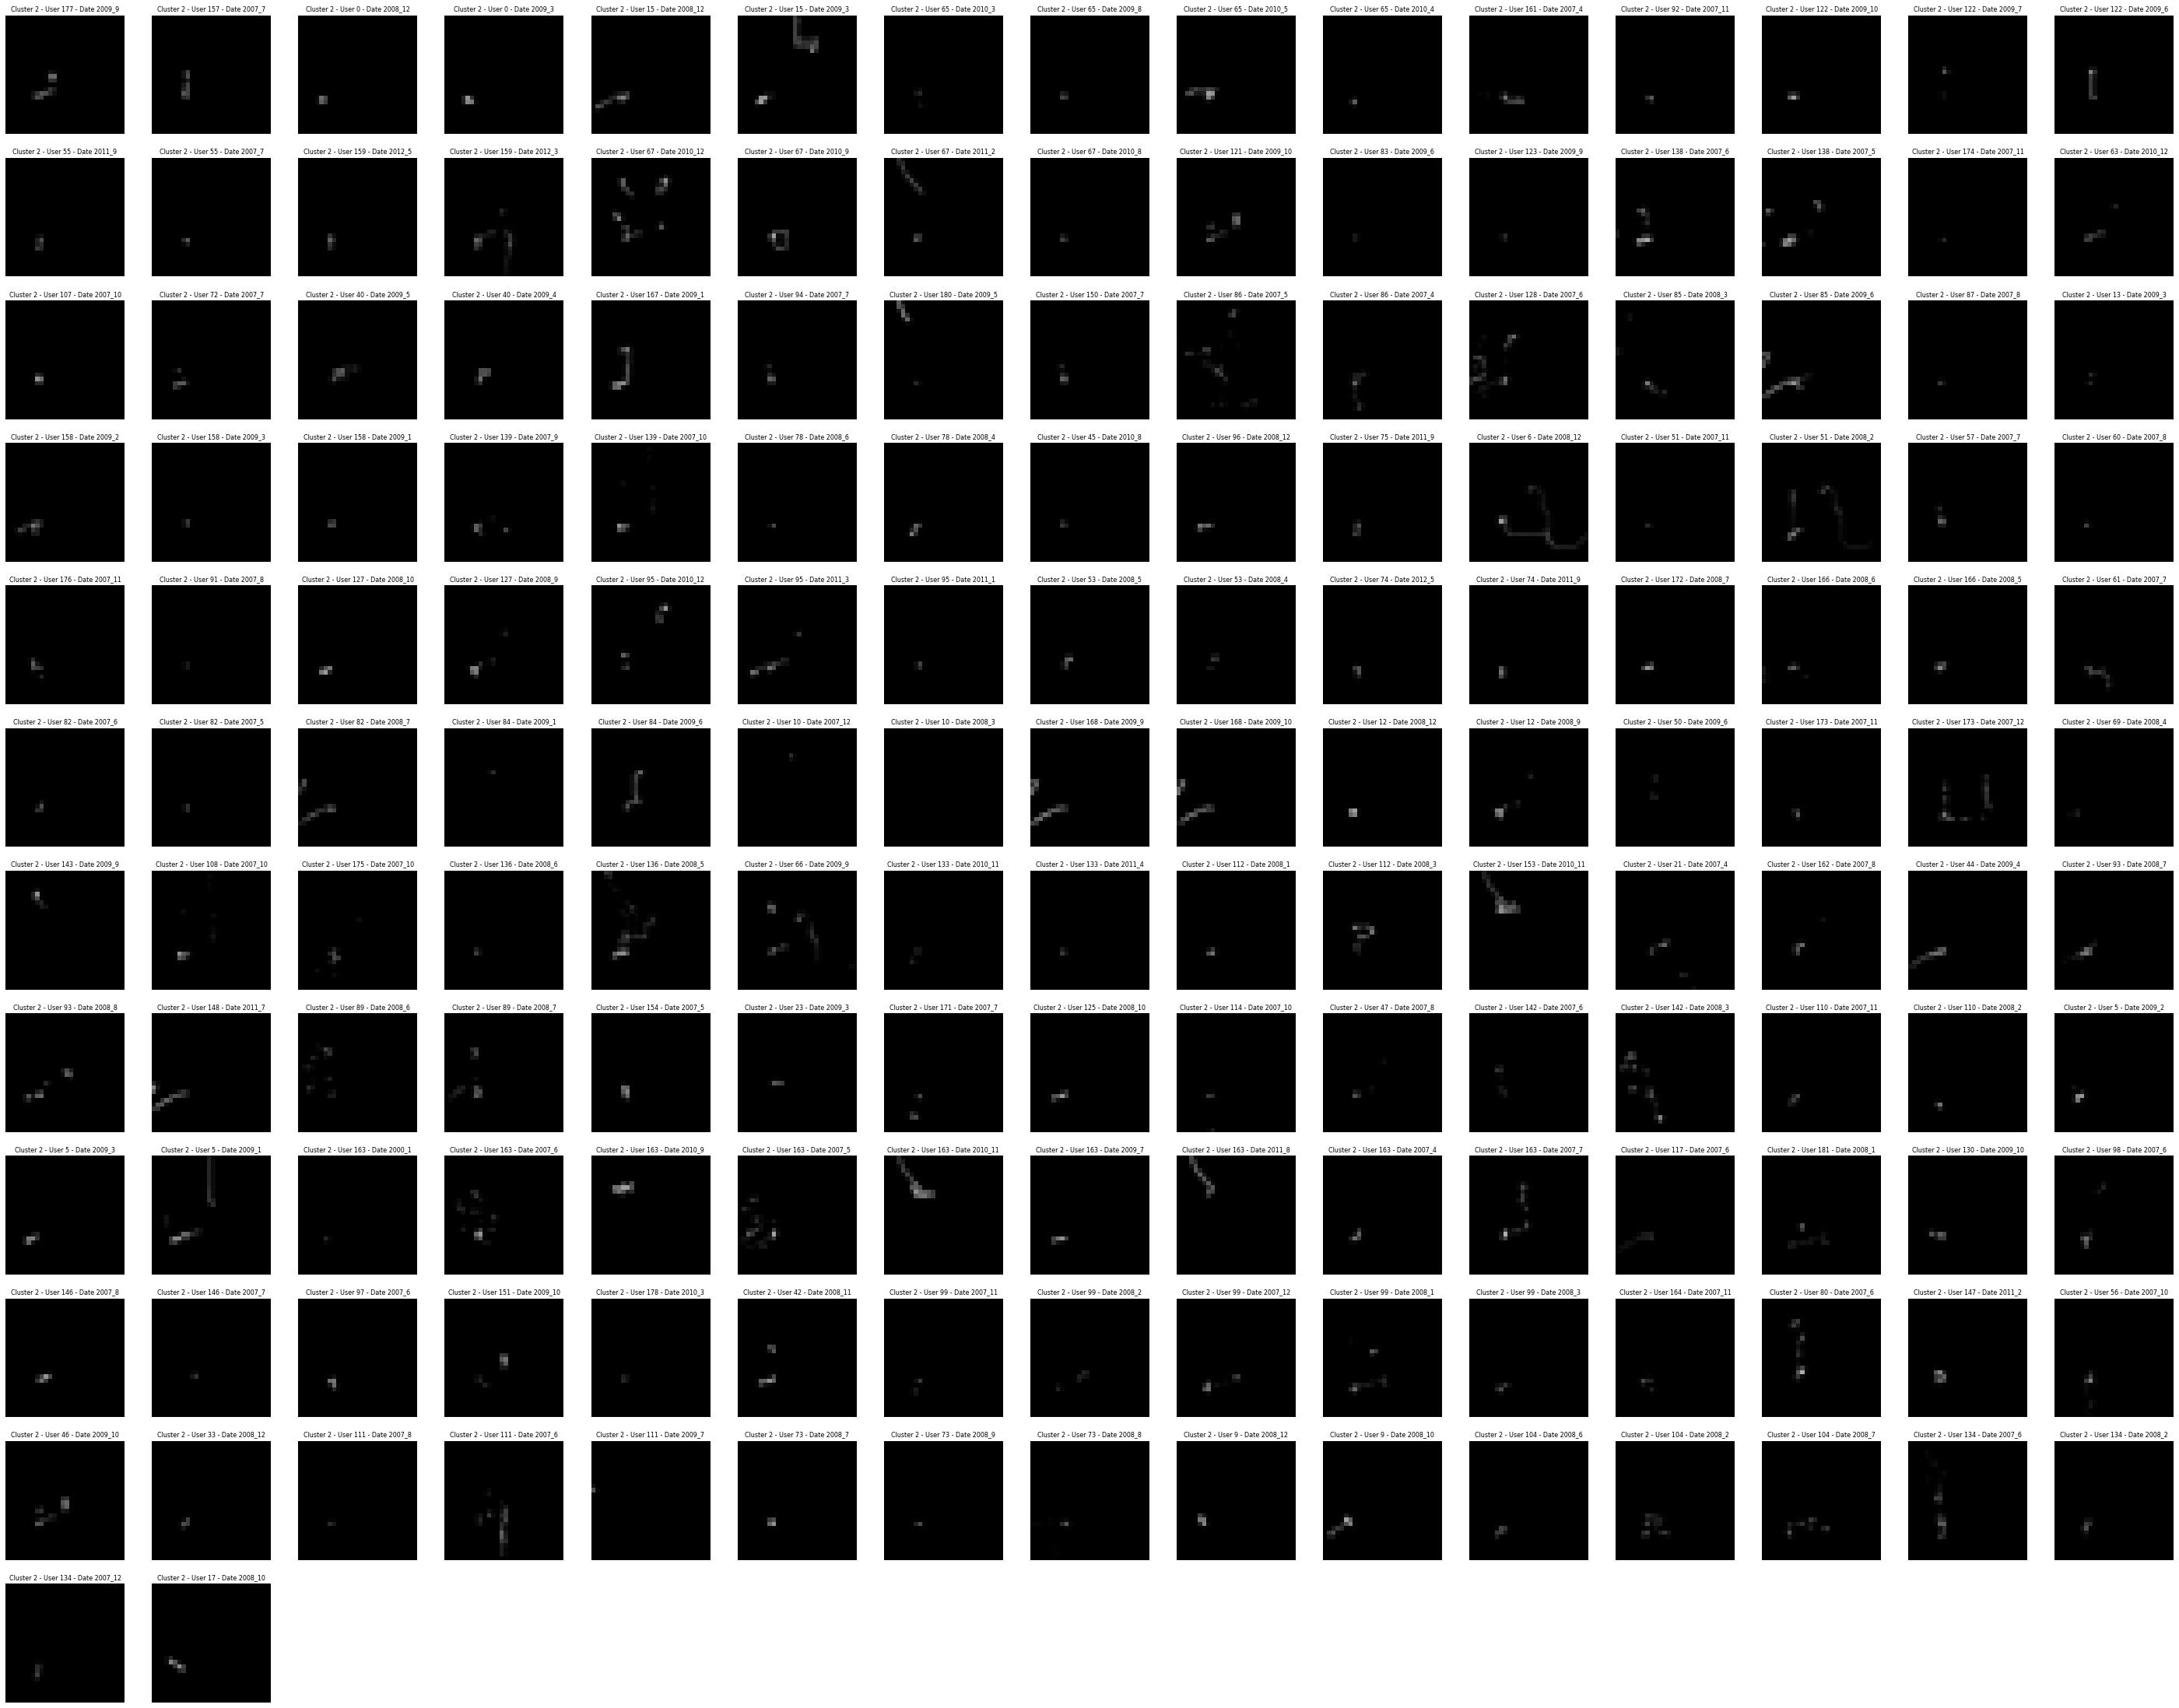

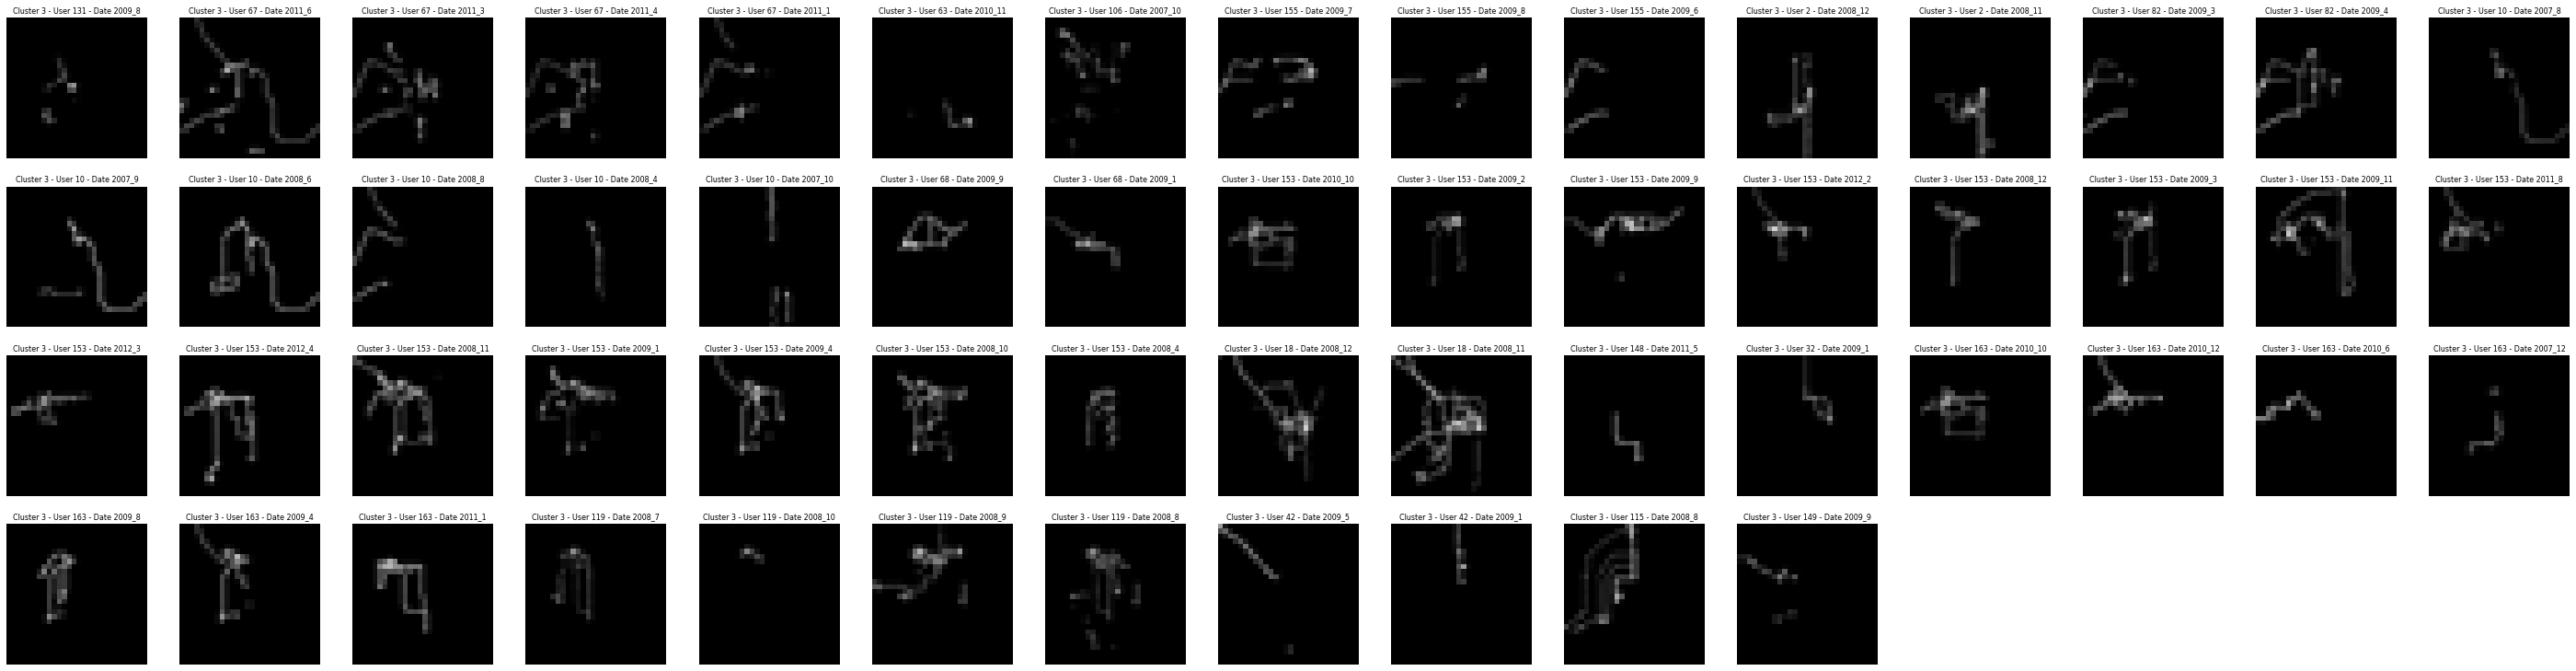

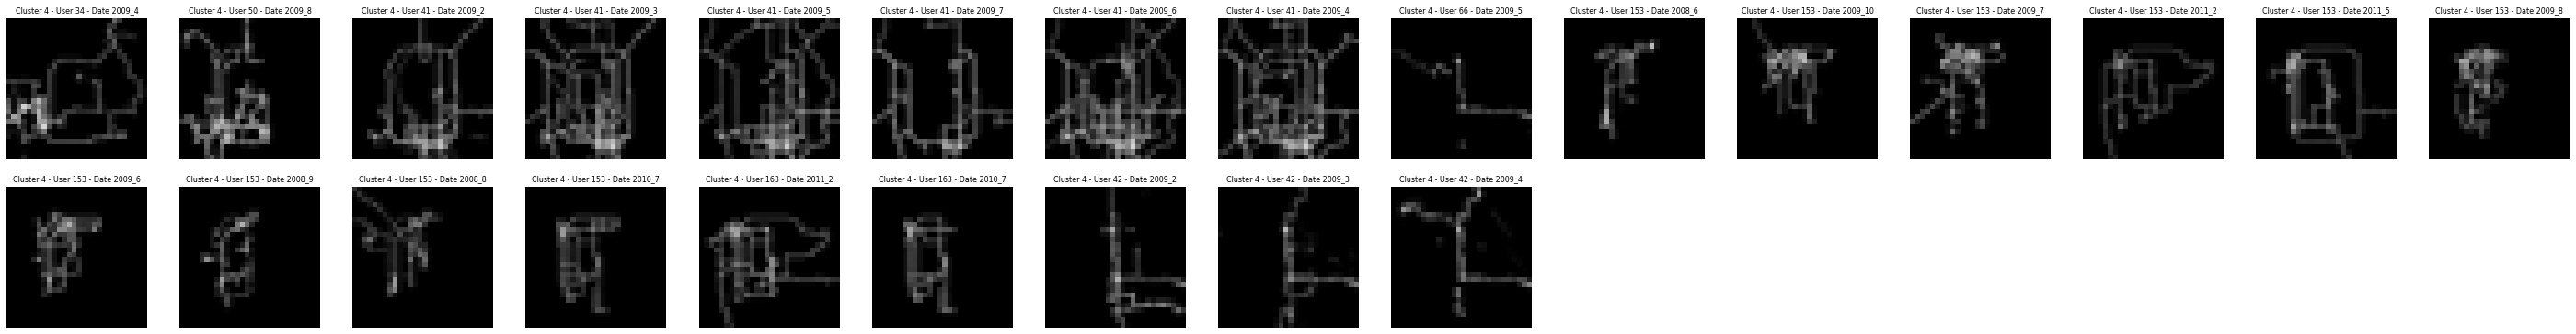

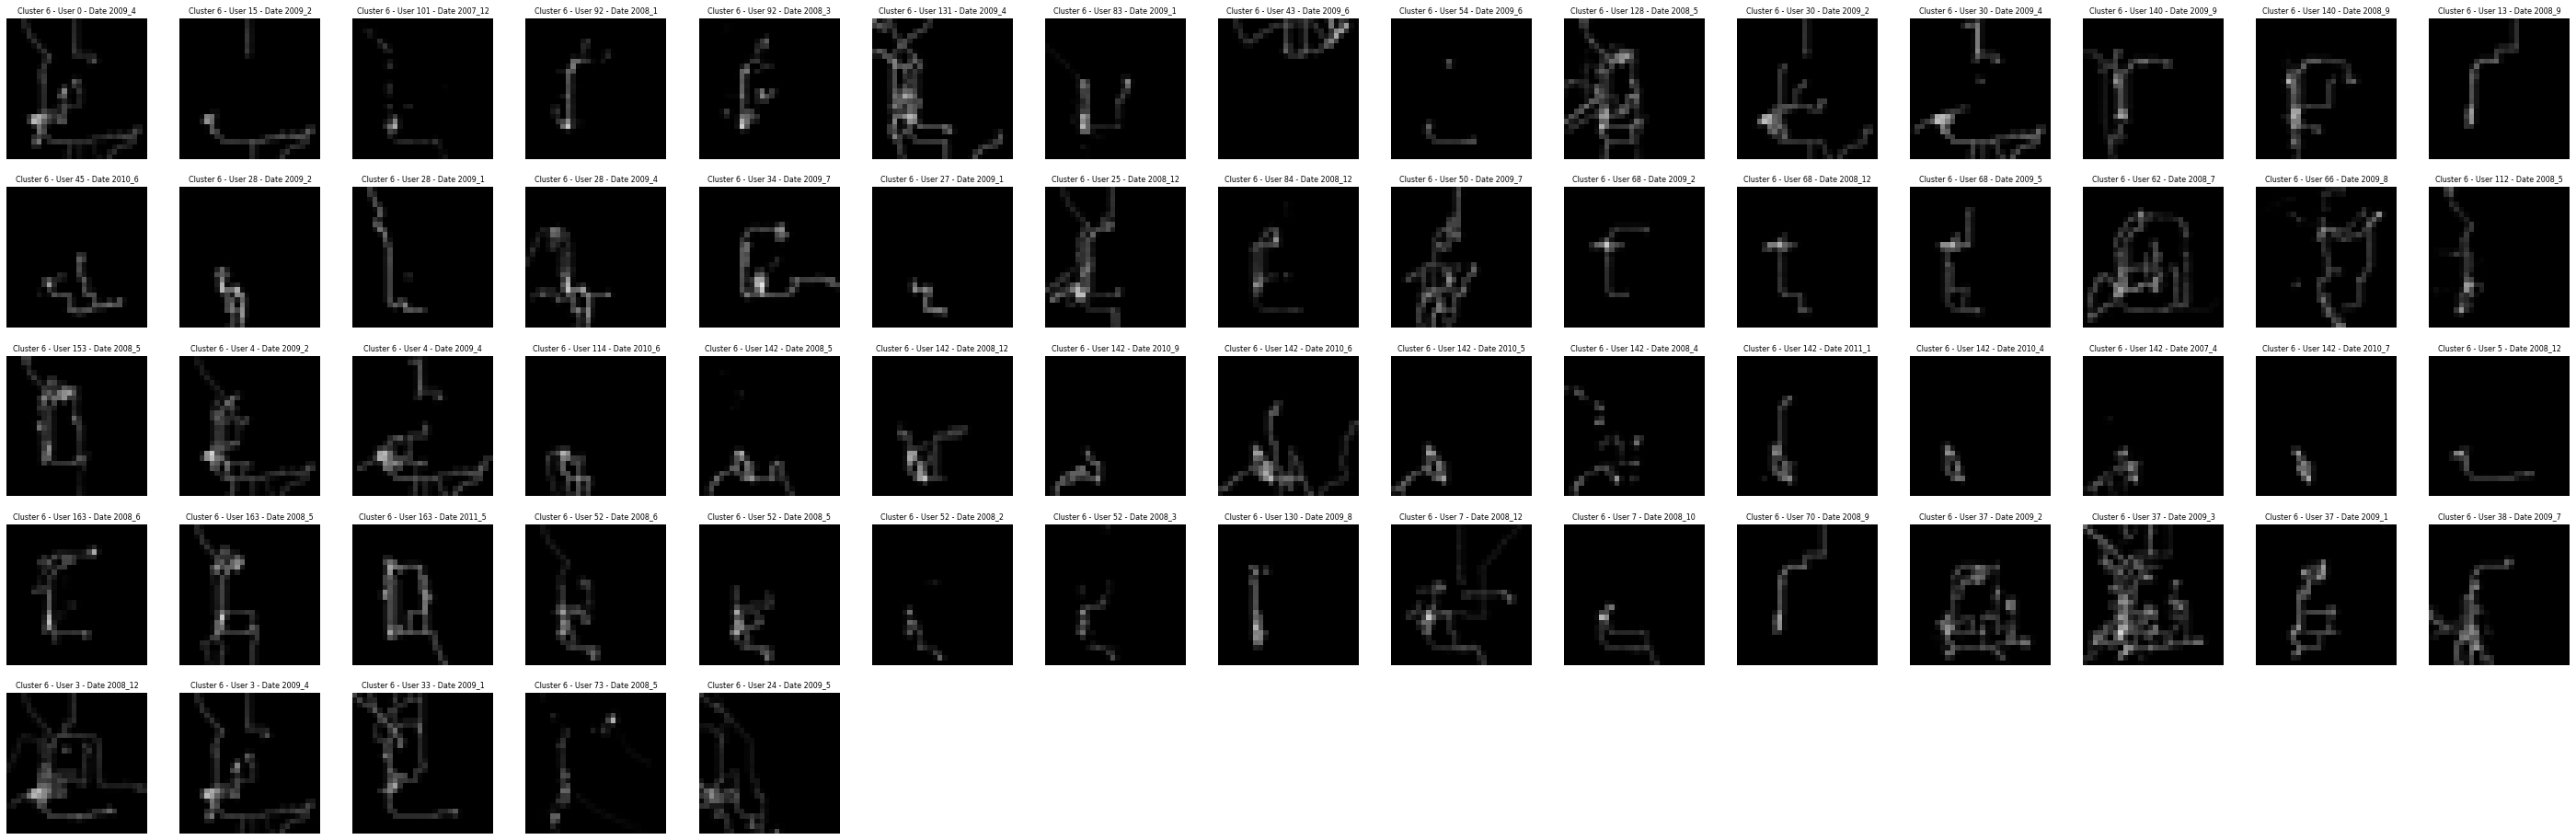

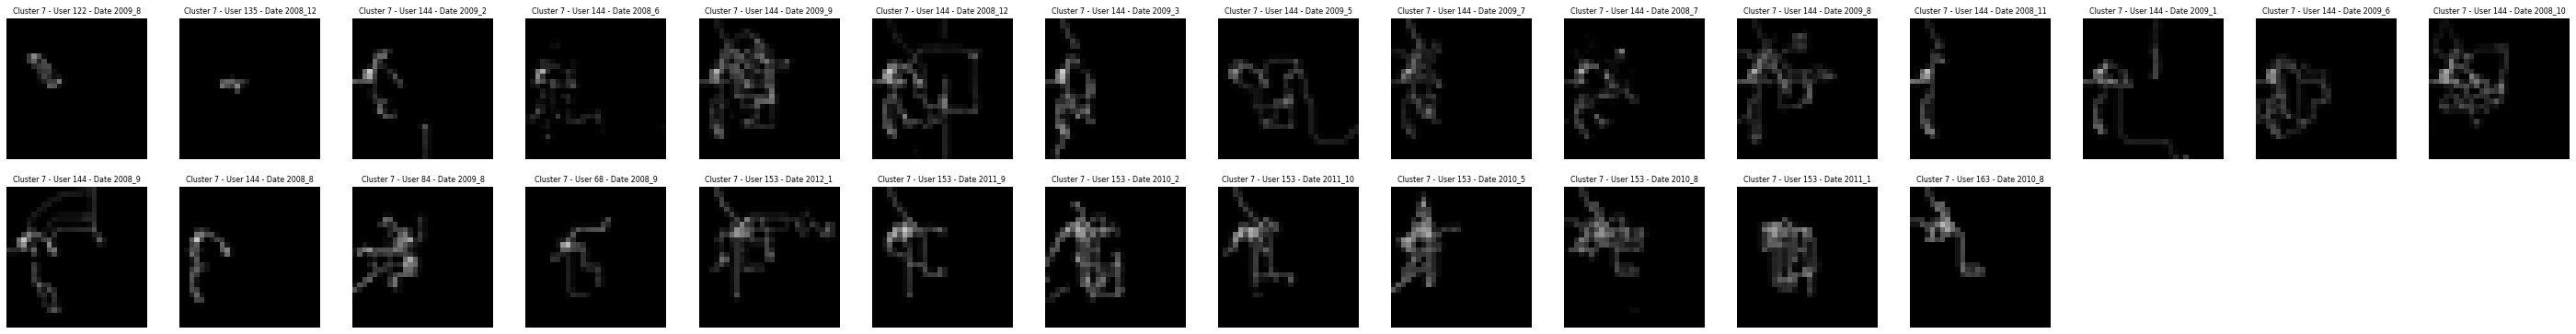

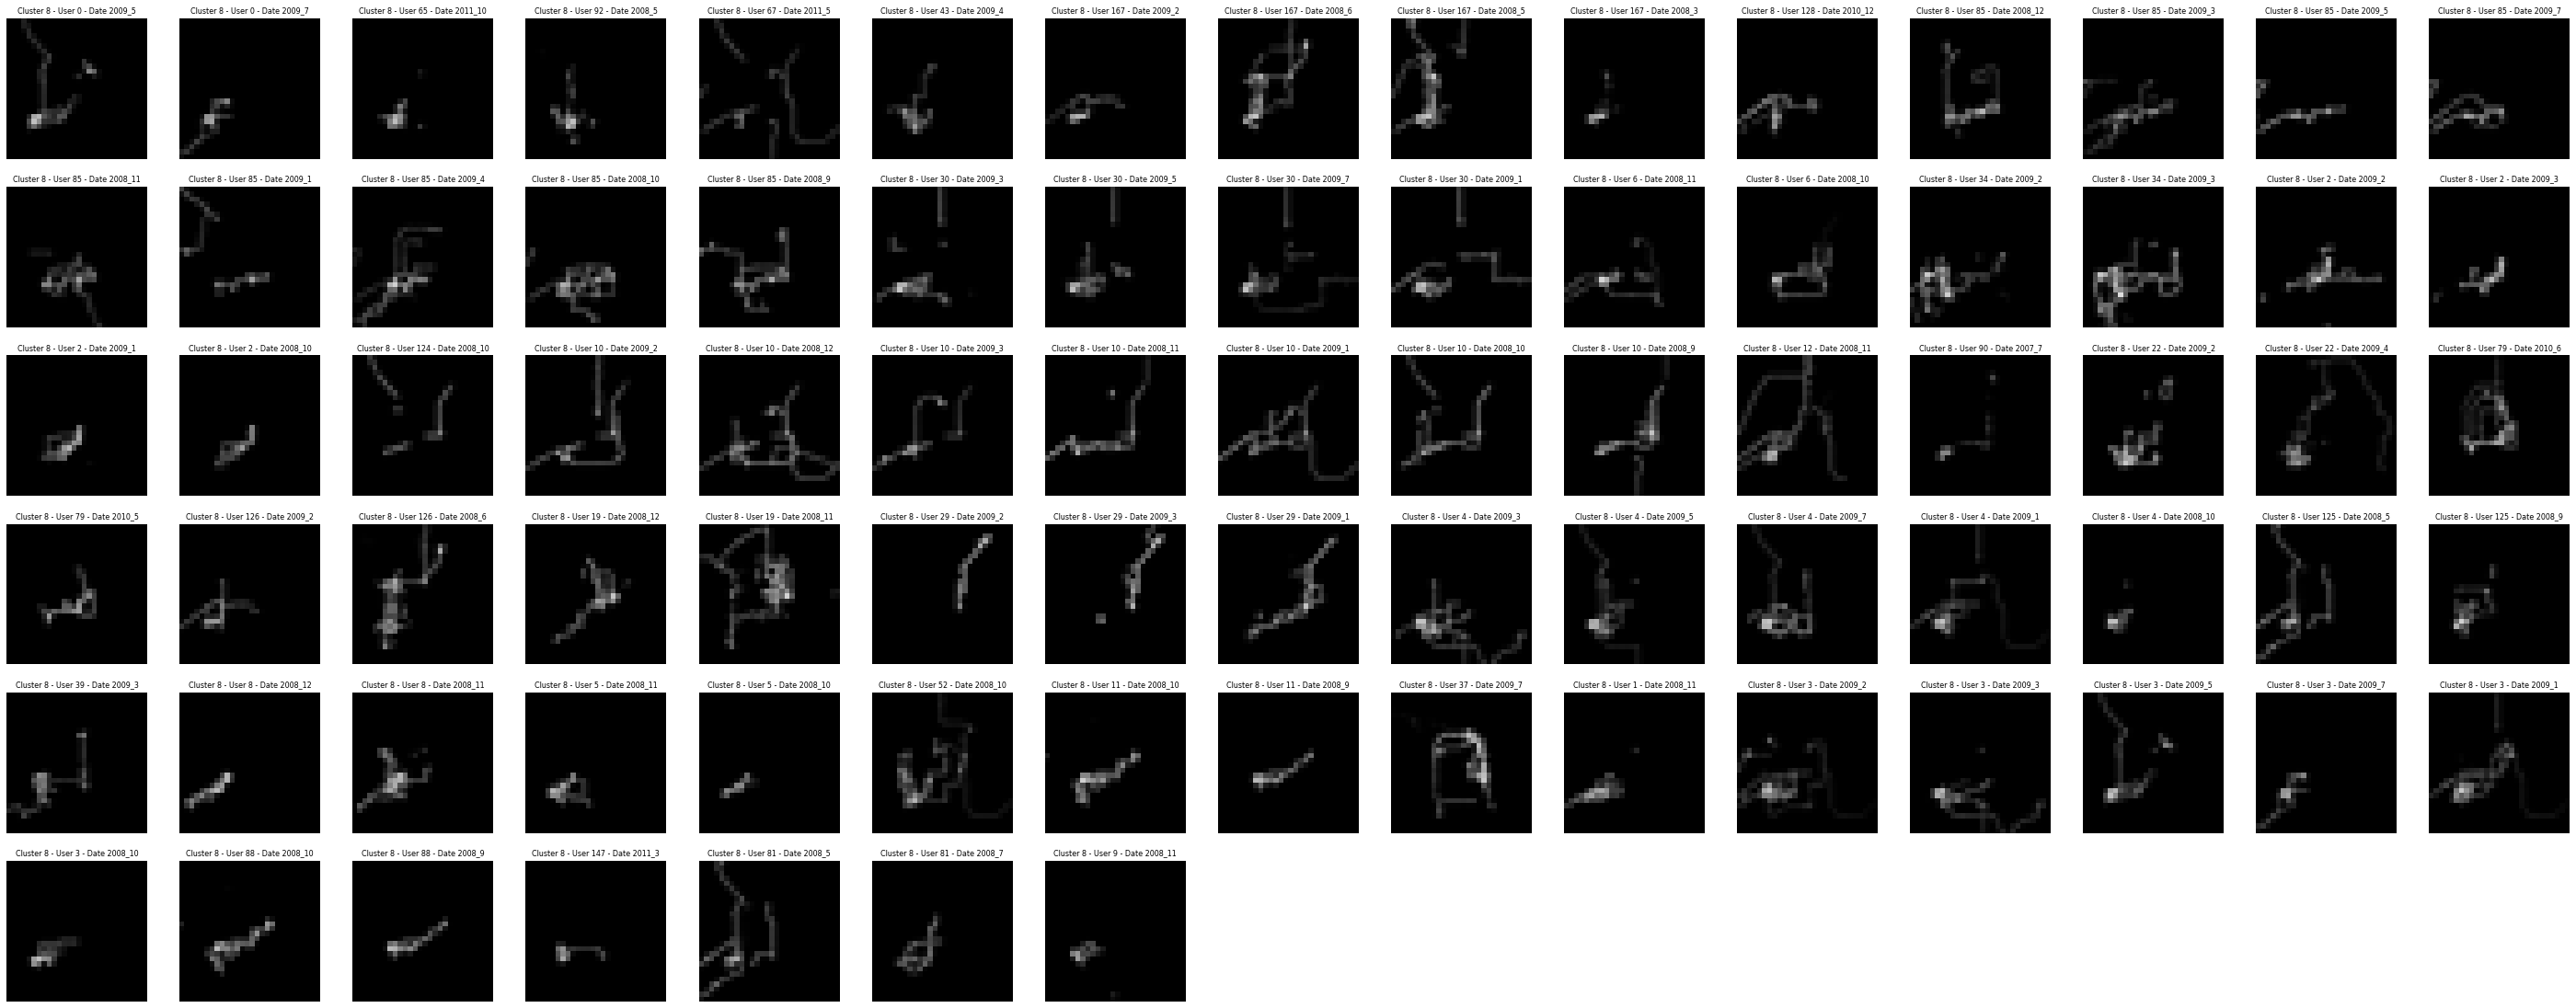

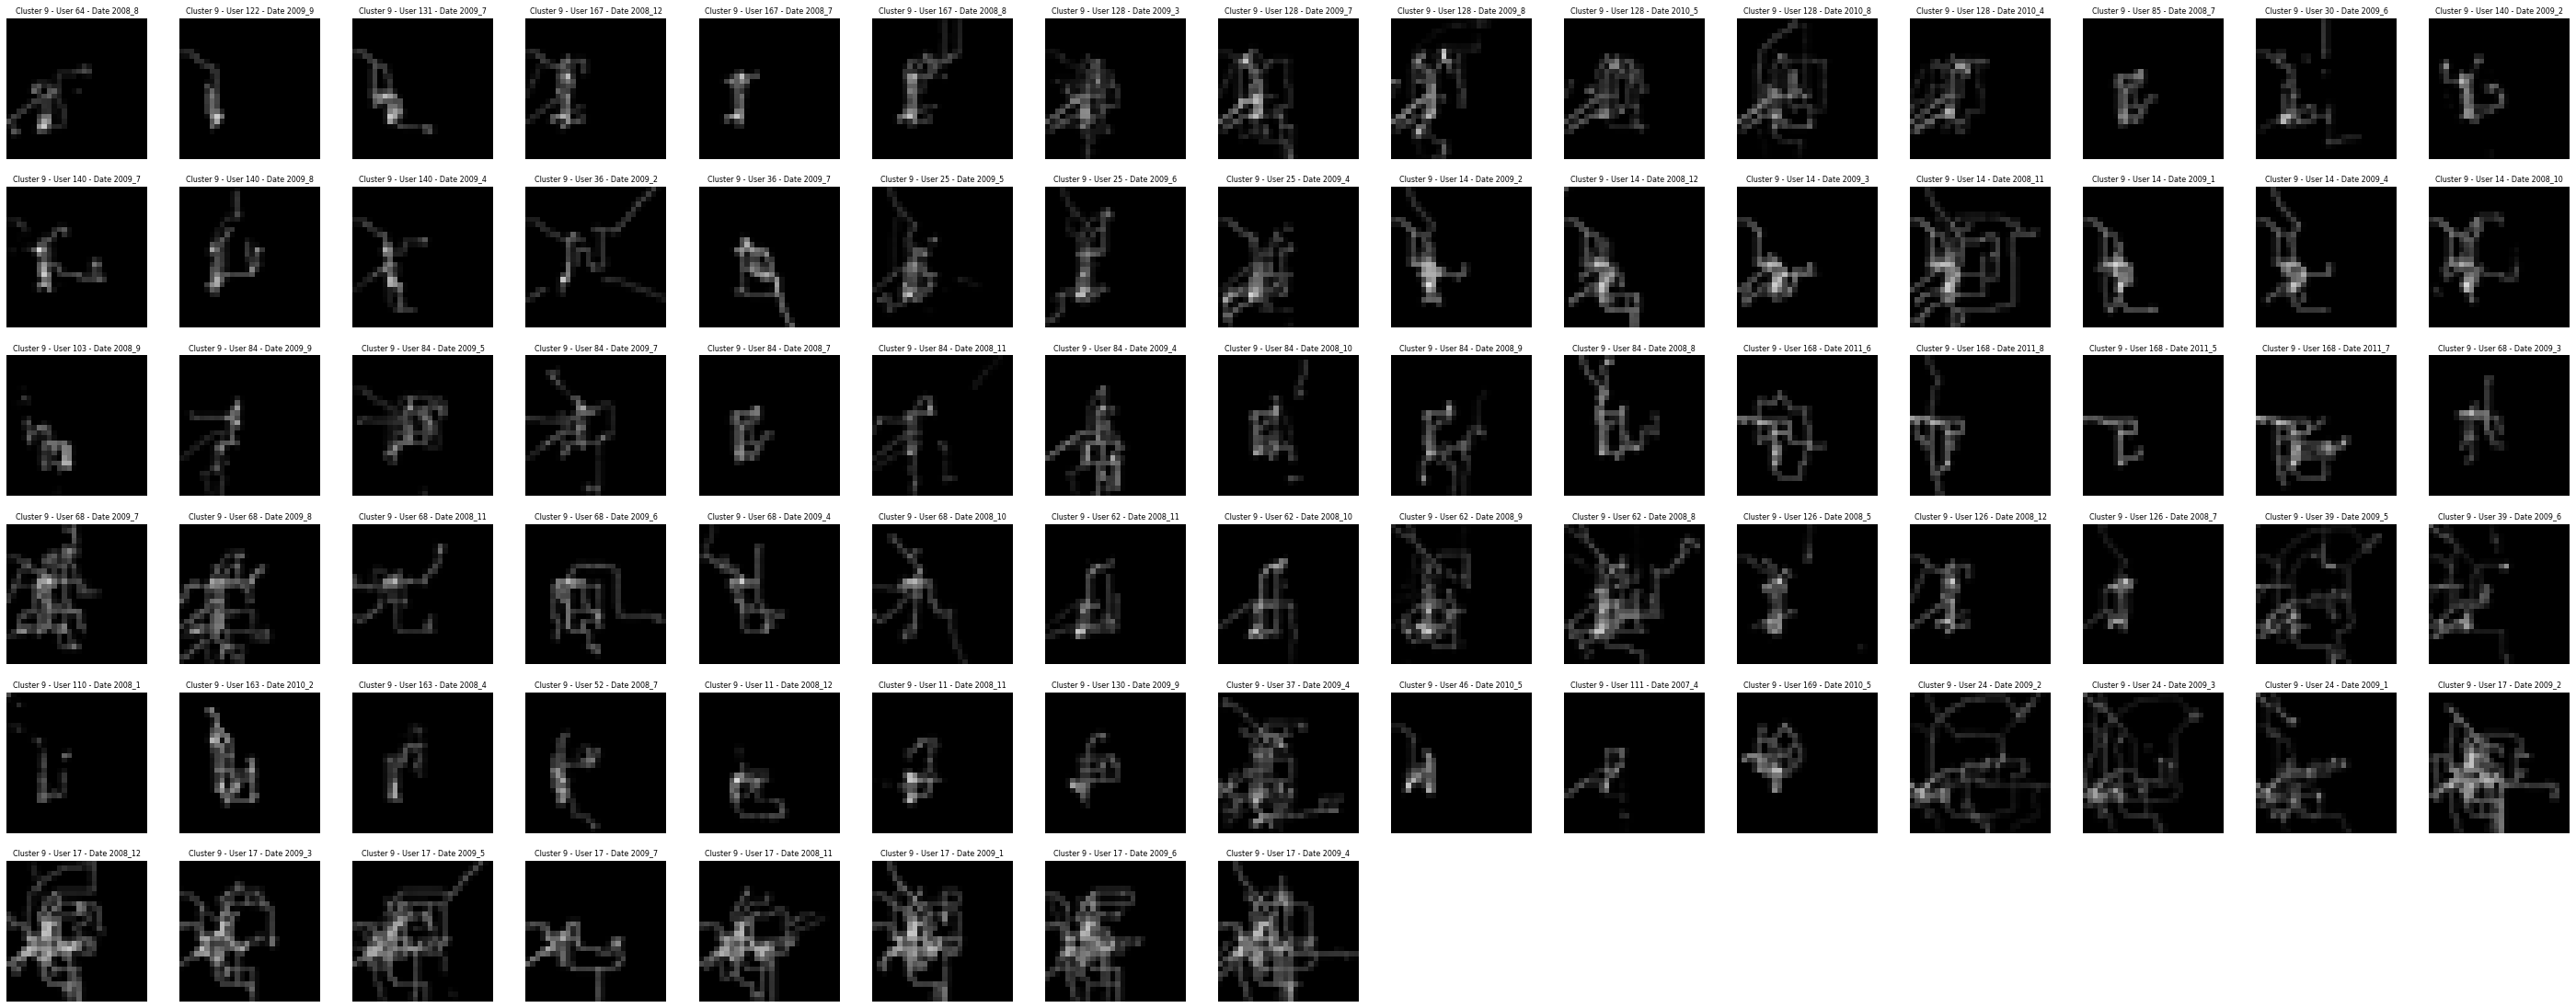

In [42]:
# Visualize all the clusters

for i in range(1,n_clust):
      view_cluster(i)

In [16]:
# Elbow plot to identify the optimal number of clusters   
# this is just incase you want to see which value for k might be the best 

sse = []
list_k = list(range(3, 20,2))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

## Cosine similarity of inputs

In [17]:
%matplotlib inline

def plot_heatmap(X, figsize=(7,7)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(X, ax=ax)

S = cosine_similarity(x)
plot_heatmap(S)
print(S.shape)

(843, 843)


## View SSIM Matrix of raw inputs and decoded outputs

In [ ]:
path = '/data/fiona123/GeolifeTrajectories/ResizedHeatMap_28'
df, img = createSSIMimage(path)
display(img)
img.save('ssim-28-input.png')
print(df.values.mean())
print(df.values.std())  

In [20]:
path = '/data/fiona123/GeolifeTrajectories/DecodedOutputHeatMap'
df, img = createSSIMimage(path)
display(img)
img.save('ssim-28-decoded.png')
print(df.values.mean())
print(df.values.std())  

['/data/fiona123/GeolifeTrajectories/DecodedOutputHeatMap/0.png', '/data/fiona123/GeolifeTrajectories/DecodedOutputHeatMap/1.png', '/data/fiona123/GeolifeTrajectories/DecodedOutputHeatMap/10.png', '/data/fiona123/GeolifeTrajectories/DecodedOutputHeatMap/100.png', '/data/fiona123/GeolifeTrajectories/DecodedOutputHeatMap/101.png', '/data/fiona123/GeolifeTrajectories/DecodedOutputHeatMap/102.png', '/data/fiona123/GeolifeTrajectories/DecodedOutputHeatMap/103.png', '/data/fiona123/GeolifeTrajectories/DecodedOutputHeatMap/104.png', '/data/fiona123/GeolifeTrajectories/DecodedOutputHeatMap/105.png', '/data/fiona123/GeolifeTrajectories/DecodedOutputHeatMap/106.png', '/data/fiona123/GeolifeTrajectories/DecodedOutputHeatMap/107.png', '/data/fiona123/GeolifeTrajectories/DecodedOutputHeatMap/108.png', '/data/fiona123/GeolifeTrajectories/DecodedOutputHeatMap/109.png', '/data/fiona123/GeolifeTrajectories/DecodedOutputHeatMap/11.png', '/data/fiona123/GeolifeTrajectories/DecodedOutputHeatMap/110.png', 

100%|██████████| 843/843 [20:34<00:00,  1.46s/it]


0.4587618300799129
0.24031997313037065


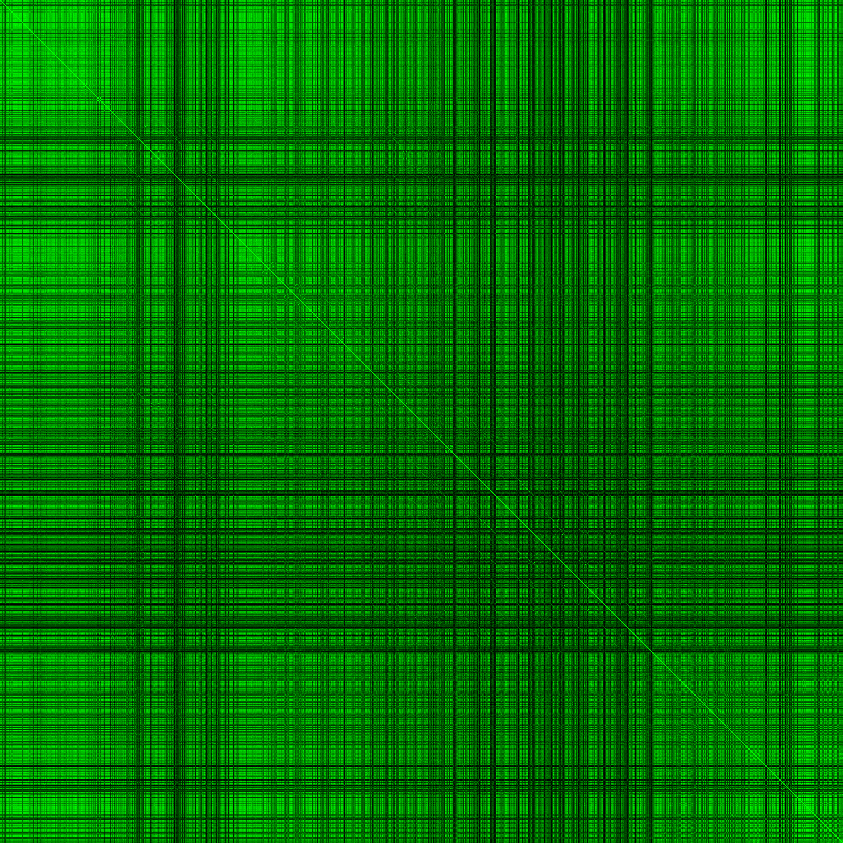

In [27]:
# Similarity for each pair of users, computed using the SSIM metric for GeoLife

# Raw input heatmap images

path="/home/NETID/fiona123/css590/scripts/Assignment0/ssim-28-input.png"
display(Image.open(path))

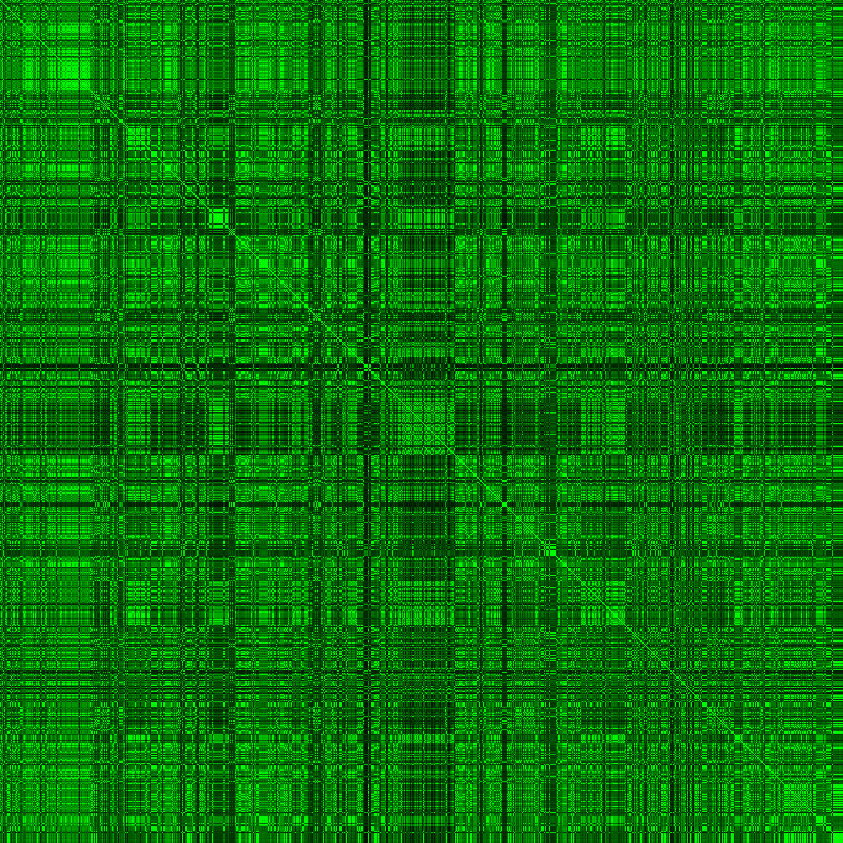

In [28]:
# Decoder layer output 

path="/home/NETID/fiona123/css590/scripts/Assignment0/ssim-28-decoded.png"
display(Image.open(path))